In [1]:
import sys

In [2]:
import numpy as np
from myimgtools import *
from mymath import *
from PDHGtools import *

# Optimization problem:                                                      

# $$\min_{x\in\mathbb{R}^n} G(x) + f*h(Kx)$$
where $G(x)= 0.5|Ax-b|_2^2$, $h(x) = \tfrac{1}{2\varepsilon}||Wx||_2^2 $ and $f(x)=\mu||Kx||_{2,1}$.
Here, $W$ is a diagnal matrix $diag(w_1,w_2,\cdots,w_n)$ which is designed to detect edges by assigning weights on the pixels along edges in the image.
                                                                            

Infimal convolution problem can be converted into saddle point problem as the following.
### Saddle point problem
### $$\min_x\max_{y}<Kx,P> + G(x)-f^*(y) - h^*(y)$$
Thus, we obtain corresponding inclusion formular for this problem:
### Inclusion formular
### $$T(z)+ Bz\ni 0$$
where $z=\begin{pmatrix}x\\y\end{pmatrix}$, $T:=\begin{pmatrix} 0 &+K^*\\-K&\partial f^*(.)\end{pmatrix}$, $B:=\begin{pmatrix} \nabla G(\cdot)& \\ 0 &\nabla h^*(\cdot)\end{pmatrix}$.
We assume $B$ is lipschitz and co-coercive.

Let us consider using PDHG method with variable metric  identity $I$ plus lower rank matrix$Q=UU^T$ multiplied by $M$
$$(M+Q)(z_{k+1}-z_{k})+T(z_{k+1})\ni -Bz_k$$
where $M$ is defined as following:
$$M=\begin{pmatrix}I/\tau&-K^*\\-K&I/\sigma\end{pmatrix}$$

### Load image

In [3]:
filename = "Diana240";
img = mpimg.imread("data/" + filename + ".png"); 
img = rgb2gray(img);
(ny,nx) = np.shape(img);
print ("image dimensions: ", np.shape(img))

image dimensions:  (240, 240)


### Flatten image

In [4]:
N = nx*ny
oimg = img.reshape((N,1))

### Construct blur kernel

In [5]:
### construction of blurr kernel ###

# filter of size 2*k+1
k = 10;
s = 2*k+1;
filter = np.zeros((s,s));

### Construct Gaussian kernel


In [6]:
if False:   # construct Gaussian kernel
    sigma = 25;

    [dx,dy] = np.meshgrid(np.linspace(-k,k,s), np.linspace(-k,k,s));
    filter = np.exp(-(dx**2+dy**2)/(2.0*sigma**2));
    filter = filter/np.sum(filter);
    print(filter)
    plt.imshow(filter);
    plt.show()

In [7]:
if True: # read filter from image
    filter_img = mpimg.imread("data/filter.png");
    s = np.shape(filter_img)[0];
    filter = filter_img/np.sum(filter_img);

### Blurr operator as matrix

In [8]:
# blurr operator as matrix
A = make_filter2D(ny, nx, filter);    

### Model blurry and noisy image 

In [9]:
def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = np.random.random()
            
            if rdn < prob:
                output[i][j] = 0
            else:
                output[i][j] = image[i][j]
    return output

In [10]:
N = nx*ny;
# reshape to fit dimension of optimization variable
imgN=sp_noise(img,0.1)
b = imgN.reshape((N,1)); 
b = img.reshape((N,1)); 

#b=b+np.random.normal(0.0, 0.05, (N,1))Charkiw
b = A.dot(b) + np.random.normal(0.0, 0.05, (N,1));
#b=sp_noise(b,0.1)

b = b.flatten();

### Ouput blurred image

In [11]:
# write blurry image
mpimg.imsave(filename + "blurry.png", b.reshape(nx,ny), cmap=plt.cm.gray);

# Model

In [12]:
################################################################################
### Model ######################################################################

K = make_derivatives2D(ny, nx);
#mu = 0.1;
n = nx*ny

In [13]:
D=K@oimg[:,0]
N = len(D)
n = int(N/2)
D[0:n] = np.sqrt( D[0:n]**2+D[n:N]**2)
D[n:N] = D[0:n]
beta = 1
W = np.exp(-beta*D)

In [14]:
### Parameters
tau=0.1
sig=0.1
mu=0.01
OP={'K':K,'A':A,'b':b,'mu':mu}
Metric={'Tau':tau,'Sigma':sig,'K':K}
x=np.ones(K.shape[1])
p=np.ones(K.shape[0])
z={'x':x,'p':p}

In [15]:
#test####
num_x=len(x)
num_p=len(p)



Dx=np.ones(num_x)
Dp=np.ones(num_p)
U=np.zeros(num_x+num_p)
Ux=U[0:num_x]
Up=U[num_x:num_x+num_p]
Preconditioner={'U':U,'Dx':Dx,'Dp':Dp,'Ux':Ux,'Up':Up}

### 0SR1


In [17]:
def sr1(zkm1,zk,tau, gradkm1,gradk,itr,r0,U0,s,Sign):
    xkm1 = zkm1['x']
    pkm1 = zkm1['p']
    xk = zk['x']
    pk = zk['p']
    
    
    ykx = gradk['x'] - gradkm1['x']
    skx = xk - xkm1
    yky = gradk['y'] - gradkm1['y']
    sky = pk  - pkm1
    
    s = (ykx - 1/tau*skx - K.T@sky )@skx + (yky - 1/sig*sky- K@skx)@sky
    if s>0:
        Sign = 1
    else:
        Sign = -1
        
        
    
    s = np.sqrt(np.abs(s))
    if s<10**(-6):
        U = np.zeros(len(xk)+len(pk))
        return U0,s,Sign,r0
    
    ux = (ykx - 1/tau*skx - K.T@sky)/s
    up = (yky - 1/sig*sky - K@skx)/s
    U = np.concatenate([ux,up]).flatten()
    
    
    
    #r = 1
    if itr<500:
        r = 4/(U@U)
    else:
        r = 4/(U@U)
        #r = r/(itr-499)**(1.1)
    #r = r/itr**(1.1)
    U = np.sqrt(r)* U
    
    return  U, s, Sign ,r
    
    
    
    
    
    
    
    
    
    
    

In [20]:
def LfunctionMplusQ(Preconditioner,OP,Metric,z_init,a,Sign,gradk):
    #Load parameters
    Dx=Preconditioner['Dx']
    
    Dp=Preconditioner['Dp']
    
    z = z_init.copy()
    #U=Preconditioner['U']
    #u=Preconditioner['Ux']
    #v=Preconditioner['Up']
    U=Preconditioner['U']
    
    #######
#     num_x=len(Dx)
#     num_p=len(Dp)
    ##### 
    #ztemp={'x':Dx*z['x']-Ux*a,'p':Dp*z['p']-Up*a}
    ztemp={'x':z['x'],'p':z['p']}
    if Sign==1:
        zafter=PDHG_MQ(OP,Metric,ztemp,U*a,gradk)#U*a
    else:
        zafter=PDHG_MQ(OP,Metric,ztemp,-U*a,gradk)#U*a
    
    #####
    x=zafter['x']
    p=zafter['p']
   
    JTM=np.concatenate([x,p])
    JTM.flatten()
    D=np.concatenate([Dx,Dp])
    D.flatten()
    Zk = np.concatenate([z['x'],z['p']]).flatten()
   
    return    U.T.dot(JTM-Zk)-a #U.T.dot(1/D*JTM-U*a)-a

In [21]:
def PDHG_MQ(OP,Metric,z_init,y,gradk):
    
    
    #Load parameters
    tau=Metric['Tau']
    sig=Metric['Sigma']
    mu=OP['mu']
    K=OP['K']
    A=OP['A']
    b=OP['b']
    gradkx = gradk['x']
    gradky = gradk['y']
    z = z_init.copy()
    # initialization
    x=z['x']
    p=z['p']
    
    
    num_x=len(x)
    num_p=len(p)
    
    y1=y[0:num_x]
    y2=y[num_x:(num_x+num_p)]
    xk=x
    pk=p

    #PDHG
    ######################        primal          ################################
    xkp1 =(-tau*y1-tau*K.T.dot(pk) - tau*gradkx + xk)
    
    
    
    ######################        dual p          ################################
    D=np.ones(num_p)
    
    p_temp=pk+sig*(K.dot(2*xkp1-xk))-sig*y2 - sig*gradky#2*x_kp1-x_k
        
    
    pkp1=prox_proj_ball(p_temp,mu)
    
   
    zkp1={'x':xkp1,'p':pkp1}
    return zkp1

The following uses NewtonMethod to solve rootfinding problem

In [22]:
def MQRootfinding_N(Preconditioner,OP,Metric,z_init, Sign,gradk,tol):
    maxiter =200
    #load parameter
    z = z_init.copy()
    U = Preconditioner['U']
    m = len(z['x'])
    N = len(z['p'])
    n=int((N+1)/2)
    Ux = U[0:m]
    Up = U[m:(N+m)]
    tau=Metric['Tau']
    sig=Metric['Sigma']
    mu=OP['mu']
    K=OP['K']
    xk = z['x']
    pk = z['p']
    gradkx = gradk['x']
    gradky = gradk['y']
    
    
    #################
    
    a = 0
    k = 0
    val_L =  LfunctionMplusQ(Preconditioner,OP,Metric,z,a,Sign,gradk)
    a = MQRootfinding(Preconditioner,OP,Metric,z_init, Sign,gradk,tol,5)
    #print('######################')
    while k<maxiter:
        
        #compute current value curr 
        xkp1 = (-tau*Ux*a-tau*K.T.dot(pk) - tau*gradkx + xk)
        p_temp = pk + sig*(K.dot(2*xkp1-xk))- sig*gradky - sig*Up*a
        #compute UPU
        pnorm=np.sqrt(p_temp[:n]**2+p_temp[n:N]**2)
        p_norm = np.append(pnorm,pnorm)
        P = (p_norm<=mu) + mu*(p_norm>mu)*(1/(p_norm+(p_norm<=mu)) - p_temp**2/(p_norm+(p_norm<=mu))**3) 
        Dshift = mu*(pnorm>mu)*(-(p_temp[:n]*p_temp[n:N])/(pnorm+(pnorm<=mu))**3) 
        #hessian
        Hessian = -Sign*tau*Ux@Ux-1 -Sign*sig*Up@(P*Up) + 2*Sign*sig*Up[0:n]@(Dshift*Up[n:N])
        

        
        k = k+1
        
        if np.abs(Hessian)>tol:
            a = a - val_L/Hessian
            val_L =  LfunctionMplusQ(Preconditioner,OP,Metric,z,a,Sign,gradk)
#             print('val_L=',val_L)
            if np.abs(val_L)<100*tol:
                return a

The following uses Bisection to solve rootfinding problem

In [23]:
def MQRootfinding(Preconditioner,OP,Metric,z_init, Sign,gradk,tol,maxit):
    # we are going to use bisection method to solve L=0 when r=1
    #nonzeroL    = find( abs(L) > 100*np.finfo(float).eps );
    
    
    #Load parameters
    U=Preconditioner['U']
    
    z = z_init.copy()
    
    x0=np.concatenate([z['x'],z['p']])
    
    
    #before processing
    
    bound=100+norm(U)*(2*norm(x0))#+norm(ProxB_l1(0,tau,D)))# coRootfinding_r1(x,D,v,tau,maxit):upute the bound before using bisection method
    k=0

    if LfunctionMplusQ(Preconditioner,OP,Metric,z,bound,Sign,gradk) >0:
        c1=-bound
        c2=bound
    else:
        c1=bound
        c2=-bound
    ak=bound
    
    while k<maxit:
        k=k+1
        akm1=ak
        ak=(c1+c2)/2
        #print('C2=%.3f,ak=%.3f'%(c2,ak))
        if LfunctionMplusQ(Preconditioner,OP,Metric,z,ak,Sign,gradk)>0:
            c2=ak
        else:
            c1=ak
        diff=np.abs(ak-akm1)
        if (k>1)&(diff<tol):
            return ak
    return ak

In [24]:
def PDHG_MplusQ(Preconditioner, OP,Metric,z_initial,NumOfIter,check=10,Sign=1,condition=0,acc=0,rlx=0,nacc=0):
    #M=Dx+uu^T    -K^*
    #   -K             Dy+vv^T
    ######## loading ###############
    
    U = Preconditioner['U']
    z = z_initial.copy() 
    
    r = 1
    s = 0
    Tau=Metric['Tau']
    Sig=Metric['Sigma']
    K=Metric['K']
    num_x=len(Dx)
    num_p=len(Dp)
    u=U[0:num_x]
    v=U[(num_x):(num_p+num_x)]
    x=z['x']
    p=z['p']
    z0=z.copy()
    z_1=z.copy()
    b = OP['b']
    gradkx = A.T@(A@z['x']-b)
    gradky = (1/W)*(1/W)*z['p']
    gradk = {'x':gradkx,'y':gradky}
    a = 0
    alphak = 0
    
    
    tol=1*np.finfo(float).eps
    gap=cal_primal_gap_for_infimal_convolution(A,K,b,z['x'],z['p'],OP['mu'])
    #cal_primal_dual_gap_ROF(A,K,b,z['x'],z['p'],OP['mu'])
    GAP=[gap]
    Alphak = []
    print ('iter:start, gap: %f' %  gap)
    ITER = 0
    for iter in range(NumOfIter):
        z_1=z0
        z0=z.copy()
        gradkm1 = gradk.copy()
        ####### accelerate ######
        if (acc==1)&(iter>0):
            
            
            
            #1. compute ||z_k -z_{k-1}||
            square_of_diff= (z0['x'] - z_1['x'])@(z0['x'] - z_1['x'])+(z0['p'] - z_1['p'])@(z0['p'] - z_1['p'])
            max_diff = np.max((np.sqrt(square_of_diff),square_of_diff))
                
            
            #2. compute accelerate param: ac    
            ac =  1/((iter)**(1.1)*(max_diff))
            ac = (ac<1)*ac + (ac>=1)
            
            #3. compute extrapolation
            z['x'] = z0['x'] + ac*(z0['x'] - z_1['x'])
            z['p'] = z0['p'] + ac*(z0['p'] - z_1['p'])
        
        #########################
        #### update grad ########
        gradk['x'] = A.T@(A@z['x']-b)
        gradk['y'] = (1/W)*(1/W)*z['p']
        #########################
        # calculating a
        tol=1*np.finfo(float).eps
        a = MQRootfinding_N(Preconditioner,OP,Metric,z, Sign,gradk,tol)
        
        val_L=LfunctionMplusQ(Preconditioner,OP,Metric,z,a,Sign,gradk)
        
        if(iter % check == 0):
            print('L value=%f'%val_L) 
        #########################
        if Sign==-1:
            y=-U*a#U*a
        else:
            y=U*a
        #########################
        z=PDHG_MQ(OP,Metric,z,y,gradk)
        #### update grad ########
        gradk['x'] = A.T@(A@z['x']-b)
        gradk['y'] = (1/W)*(1/W)*z['p']
        ####### accelerate ######
        if nacc=='nesterov':
            z['x'] = z['x'] + (iter-2)/((iter+1))*(z['x'] - z0['x'])
            z['p'] = z['p'] + (iter-2)/((iter+1))*(z['p'] - z0['p'])
#        
        ####### relaxation ######
        if rlx == 1:
            alphak,v_x,v_p = cal_param(z,z0,gradk,gradkm1, Metric)
            z = relx_step(z,z0,alphak,v_x,v_p)
            Alphak.append(alphak)
        #########################################
        #checking breaking condition
        gap=cal_primal_gap_for_infimal_convolution(A,K,b,z['x'],z['p'],OP['mu'])
        
        if (iter % check == 0):
            print ('iter: %d, gap: %f' % (iter, gap));
            GAP.append(gap)
            
        if (gap < tol):
            breakvalue = 1;
            break;
        
        ############ updating U######################
        
        
        if iter>2:
            U,s,Sign,r = sr1(z0,z,tau, gradkm1,gradk,iter,r,U/r,s,Sign)
            
            if condition ==0:
                U = 0*U
            
            
            
        #Tempx=(2*z0['x']-1*z['x']-z_1['x'])
        #Tempp=(2*z0['p']-1*z['p']-z_1['p'])
        #Ux=((1/Tau*Tempx-K.T.dot(Tempp))) #+K.T.dot(z0['p']-z['p']) )
       
        #Up=((-K.dot(Tempx)+1/Sig*Tempp) ) #+ K.dot(z['x']-z0['x']) )
        
        #scaling=Ux.dot((z['x']-z0['x']))+Up.dot((z['p']-z0['p']))
        ##############################################
        
        #if scaling>0:
            #Sign=1
        #else:
            #Sign=1
            #scaling=np.abs(scaling)
            
        #Ux=1000*Ux
        #Up=1000*Up
        #U=(np.concatenate([Ux,Up])).flatten()
        Preconditioner['U'] = U#(np.concatenate([Ux,Up])).flatten()
        
        ######################################
    #########################################
    return z, GAP, Alphak

\begin{equation}
\begin{split}
b_k&:=\langle z_k-\hat z_k,M_k(z_k-\hat z_k)-B(z_k)+B(\hat z_k) \rangle\\
a&:=\vert\vert M_k(z_k-\hat z_k)+B(\hat z_k)- B(z_k)\vert\vert ^2\\
\end{split}
\end{equation}
$$v:=M_k(z_k-\hat z_k)+B(\hat z_k)- B(z_k)$$
$$\alpha_k = \frac{b_k}{a}$$

In [25]:
def cal_param(zk,zkm1,gradk,gradkm1, Metric):
    # compute the parameter $alpha_k$
    #input:
    #output: alpha_k
    #load parameters 
    Tau = Metric['Tau']
    Sig = Metric['Sigma']
    K = Metric['K']
    gradkx = gradk['x']
    gradky = gradk['y']
    gradkm1x = gradkm1['x']
    gradkm1y = gradkm1['y']
    #load input
    xk = zk['x']
    pk = zk['p']
    xkm1 = zkm1['x']
    pkm1 = zkm1['p']
    # z-hat z
    d_x = xkm1 - xk
    d_p = pkm1 - pk
    #compute vector v
    v_x = 1/Tau * (d_x) - K.T@(d_p) + gradkx -gradkm1x
    v_p = 1/Sig * (d_p) - K@(d_x)+ gradky -gradkm1y
    #compute a 
    a = v_x@v_x + v_p@v_p
    #compute b_k
    bk = d_x@v_x + d_p@v_p
    return bk/a,v_x,v_p

In [26]:
def relx_step(zk,zkm1,alphak,v_x,v_p):
    zk['x'] = zkm1['x'] - 0.5*alphak*(v_x)
    zk['p'] = zkm1['p'] - 0.5*alphak*(v_p)
    return zk

In [ ]:
def cal_primal_gap_for_infimal_convolution(A,K,b,x,p,mu):
    #computing primal and dual gap for ROF When A=identity
    #input: K matrix of derivative2D
    #       b is the noisy image
    #       x is the generated image
    #       p is the dual variable
    #       mu is the parameter before regularization term
    n=b.shape[0]
    res=A@x-b;
    
    
    
    Dx_infimal=infimal_conv_21(W,K,x,mu)
    primal=0.5*(res).dot(res)+mu*Dx_infimal; 
    gap =primal
    return gap


In [ ]:
def infimal_conv_21(W,K,x,mu):
    y_bar = K@x
    N = len(y_bar)
    n = int(N/2)
    y_hat = np.sqrt(y_bar[0:n]**2 +  y_bar[n:N]**2)
    w = W[0:n]**2/mu
    infimal_conv_norm = ((y_hat - 1/w)<=0)@(0.5*w*y_hat**2) + ((y_hat - 1/w)>0)@(y_hat-1/(2*w))
    return infimal_conv_norm

In [117]:
Zmq,GAP,_=PDHG_MplusQ(Preconditioner, OP,Metric,z,10000,10,0,0,0)

iter:start, gap: 9478.226830
L value=0.000000
iter: 0, gap: 7715.218043
L value=0.000000
iter: 10, gap: 1077.450305
L value=0.000000
iter: 20, gap: 230.047490
L value=0.000000
iter: 30, gap: 113.937573
L value=0.000000
iter: 40, gap: 94.346731
L value=0.000000
iter: 50, gap: 89.102627
L value=0.000000
iter: 60, gap: 86.728544
L value=0.000000
iter: 70, gap: 85.284128
L value=0.000000
iter: 80, gap: 84.291425
L value=0.000000
iter: 90, gap: 83.567151
L value=0.000000
iter: 100, gap: 83.017892
L value=0.000000
iter: 110, gap: 82.589221
L value=0.000000
iter: 120, gap: 82.247178
L value=0.000000
iter: 130, gap: 81.969501
L value=0.000000
iter: 140, gap: 81.740933
L value=0.000000
iter: 150, gap: 81.550493
L value=0.000000
iter: 160, gap: 81.390028
L value=0.000000
iter: 170, gap: 81.253553
L value=0.000000
iter: 180, gap: 81.136634
L value=0.000000
iter: 190, gap: 81.035798
L value=0.000000
iter: 200, gap: 80.948488
L value=0.000000
iter: 210, gap: 80.872404
L value=0.000000
iter: 220, ga

L value=0.000000
iter: 1880, gap: 80.159684
L value=0.000000
iter: 1890, gap: 80.159680
L value=0.000000
iter: 1900, gap: 80.159677
L value=0.000000
iter: 1910, gap: 80.159673
L value=0.000000
iter: 1920, gap: 80.159670
L value=0.000000
iter: 1930, gap: 80.159666
L value=0.000000
iter: 1940, gap: 80.159663
L value=0.000000
iter: 1950, gap: 80.159660
L value=0.000000
iter: 1960, gap: 80.159657
L value=0.000000
iter: 1970, gap: 80.159655
L value=0.000000
iter: 1980, gap: 80.159652
L value=0.000000
iter: 1990, gap: 80.159650
L value=0.000000
iter: 2000, gap: 80.159647
L value=0.000000
iter: 2010, gap: 80.159645
L value=0.000000
iter: 2020, gap: 80.159643
L value=0.000000
iter: 2030, gap: 80.159640
L value=0.000000
iter: 2040, gap: 80.159638
L value=0.000000
iter: 2050, gap: 80.159636
L value=0.000000
iter: 2060, gap: 80.159634
L value=0.000000
iter: 2070, gap: 80.159633
L value=0.000000
iter: 2080, gap: 80.159631
L value=0.000000
iter: 2090, gap: 80.159629
L value=0.000000
iter: 2100, gap

L value=0.000000
iter: 3750, gap: 80.159587
L value=0.000000
iter: 3760, gap: 80.159587
L value=0.000000
iter: 3770, gap: 80.159587
L value=0.000000
iter: 3780, gap: 80.159587
L value=0.000000
iter: 3790, gap: 80.159587
L value=0.000000
iter: 3800, gap: 80.159587
L value=0.000000
iter: 3810, gap: 80.159587
L value=0.000000
iter: 3820, gap: 80.159587
L value=0.000000
iter: 3830, gap: 80.159587
L value=0.000000
iter: 3840, gap: 80.159587
L value=0.000000
iter: 3850, gap: 80.159587
L value=0.000000
iter: 3860, gap: 80.159587
L value=0.000000
iter: 3870, gap: 80.159587
L value=0.000000
iter: 3880, gap: 80.159587
L value=0.000000
iter: 3890, gap: 80.159587
L value=0.000000
iter: 3900, gap: 80.159587
L value=0.000000
iter: 3910, gap: 80.159587
L value=0.000000
iter: 3920, gap: 80.159587
L value=0.000000
iter: 3930, gap: 80.159587
L value=0.000000
iter: 3940, gap: 80.159587
L value=0.000000
iter: 3950, gap: 80.159587
L value=0.000000
iter: 3960, gap: 80.159587
L value=0.000000
iter: 3970, gap

L value=0.000000
iter: 5620, gap: 80.159587
L value=0.000000
iter: 5630, gap: 80.159587
L value=0.000000
iter: 5640, gap: 80.159587
L value=0.000000
iter: 5650, gap: 80.159587
L value=0.000000
iter: 5660, gap: 80.159587
L value=0.000000
iter: 5670, gap: 80.159587
L value=0.000000
iter: 5680, gap: 80.159587
L value=0.000000
iter: 5690, gap: 80.159587
L value=0.000000
iter: 5700, gap: 80.159587
L value=0.000000
iter: 5710, gap: 80.159587
L value=0.000000
iter: 5720, gap: 80.159587
L value=0.000000
iter: 5730, gap: 80.159587
L value=0.000000
iter: 5740, gap: 80.159587
L value=0.000000
iter: 5750, gap: 80.159587
L value=0.000000
iter: 5760, gap: 80.159587
L value=0.000000
iter: 5770, gap: 80.159587
L value=0.000000
iter: 5780, gap: 80.159587
L value=0.000000
iter: 5790, gap: 80.159587
L value=0.000000
iter: 5800, gap: 80.159587
L value=0.000000
iter: 5810, gap: 80.159587
L value=0.000000
iter: 5820, gap: 80.159587
L value=0.000000
iter: 5830, gap: 80.159587
L value=0.000000
iter: 5840, gap

L value=0.000000
iter: 7490, gap: 80.159587
L value=0.000000
iter: 7500, gap: 80.159587
L value=0.000000
iter: 7510, gap: 80.159587
L value=0.000000
iter: 7520, gap: 80.159587
L value=0.000000
iter: 7530, gap: 80.159587
L value=0.000000
iter: 7540, gap: 80.159587
L value=0.000000
iter: 7550, gap: 80.159587
L value=0.000000
iter: 7560, gap: 80.159587
L value=0.000000
iter: 7570, gap: 80.159587
L value=0.000000
iter: 7580, gap: 80.159587
L value=0.000000
iter: 7590, gap: 80.159587
L value=0.000000
iter: 7600, gap: 80.159587
L value=0.000000
iter: 7610, gap: 80.159587
L value=0.000000
iter: 7620, gap: 80.159587
L value=0.000000
iter: 7630, gap: 80.159587
L value=0.000000
iter: 7640, gap: 80.159587
L value=0.000000
iter: 7650, gap: 80.159587
L value=0.000000
iter: 7660, gap: 80.159587
L value=0.000000
iter: 7670, gap: 80.159587
L value=0.000000
iter: 7680, gap: 80.159587
L value=0.000000
iter: 7690, gap: 80.159587
L value=0.000000
iter: 7700, gap: 80.159587
L value=0.000000
iter: 7710, gap

L value=0.000000
iter: 9360, gap: 80.159587
L value=0.000000
iter: 9370, gap: 80.159587
L value=0.000000
iter: 9380, gap: 80.159587
L value=0.000000
iter: 9390, gap: 80.159587
L value=0.000000
iter: 9400, gap: 80.159587
L value=0.000000
iter: 9410, gap: 80.159587
L value=0.000000
iter: 9420, gap: 80.159587
L value=0.000000
iter: 9430, gap: 80.159587
L value=0.000000
iter: 9440, gap: 80.159587
L value=0.000000
iter: 9450, gap: 80.159587
L value=0.000000
iter: 9460, gap: 80.159587
L value=0.000000
iter: 9470, gap: 80.159587
L value=0.000000
iter: 9480, gap: 80.159587
L value=0.000000
iter: 9490, gap: 80.159587
L value=0.000000
iter: 9500, gap: 80.159587
L value=0.000000
iter: 9510, gap: 80.159587
L value=0.000000
iter: 9520, gap: 80.159587
L value=0.000000
iter: 9530, gap: 80.159587
L value=0.000000
iter: 9540, gap: 80.159587
L value=0.000000
iter: 9550, gap: 80.159587
L value=0.000000
iter: 9560, gap: 80.159587
L value=0.000000
iter: 9570, gap: 80.159587
L value=0.000000
iter: 9580, gap

In [115]:
Preconditioner['U']=np.zeros(num_x+num_p)
maxiter = 900
#Zmq2,GAP2,_=PDHG_MplusQ(Preconditioner, OP,Metric,z,maxiter,10,0,0,0) #original
Zmq3,GAP3,_=PDHG_MplusQ(Preconditioner, OP,Metric,z,maxiter,10,0,1,1) #inertial+QN
Zmq4,GAP4,Alphak=PDHG_MplusQ(Preconditioner, OP,Metric,z,maxiter,10,0,1,0,1)#relaxation
Zmq5,GAP5,_=PDHG_MplusQ(Preconditioner, OP,Metric,z,maxiter,10,0,1,0) #QN


iter:start, gap: 9478.226830
L value=0.000000
iter: 0, gap: 7715.218043
L value=0.000000
iter: 10, gap: 447.800285
L value=0.000000
iter: 20, gap: 106.655730
L value=0.000000
iter: 30, gap: 89.567534
L value=0.000000
iter: 40, gap: 85.820677
L value=0.000000
iter: 50, gap: 84.012136
L value=0.000000
iter: 60, gap: 82.951792
L value=0.000000
iter: 70, gap: 82.268091
L value=0.000000
iter: 80, gap: 81.798845
L value=0.000000
iter: 90, gap: 81.461987
L value=0.000000
iter: 100, gap: 81.212874
L value=0.000000
iter: 110, gap: 81.023797
L value=0.000000
iter: 120, gap: 80.876953
L value=0.000000
iter: 130, gap: 80.762108
L value=0.000000
iter: 140, gap: 80.669845
L value=0.000000
iter: 150, gap: 80.594354
L value=0.000000
iter: 160, gap: 80.532813
L value=0.000000
iter: 170, gap: 80.481432
L value=0.000000
iter: 180, gap: 80.438209
L value=0.000000
iter: 190, gap: 80.402116
L value=0.000000
iter: 200, gap: 80.371359
L value=0.000000
iter: 210, gap: 80.345039
L value=0.000000
iter: 220, gap:

L value=0.000000
iter: 90, gap: 81.604596
L value=0.000000
iter: 100, gap: 81.337250
L value=0.000000
iter: 110, gap: 81.132162
L value=0.000000
iter: 120, gap: 80.972044
L value=0.000000
iter: 130, gap: 80.845239
L value=-0.000000
iter: 140, gap: 80.743126
L value=0.000000
iter: 150, gap: 80.659661
L value=0.000000
iter: 160, gap: 80.590598
L value=0.000000
iter: 170, gap: 80.532924
L value=0.000000
iter: 180, gap: 80.484332
L value=0.000000
iter: 190, gap: 80.443163
L value=0.000000
iter: 200, gap: 80.408127
L value=0.000000
iter: 210, gap: 80.378128
L value=0.000000
iter: 220, gap: 80.352350
L value=0.000000
iter: 230, gap: 80.330084
L value=0.000000
iter: 240, gap: 80.310773
L value=0.000000
iter: 250, gap: 80.293967
L value=0.000000
iter: 260, gap: 80.279288
L value=0.000000
iter: 270, gap: 80.266439
L value=0.000000
iter: 280, gap: 80.255152
L value=0.000000
iter: 290, gap: 80.245205
L value=0.000000
iter: 300, gap: 80.236418
L value=0.000000
iter: 310, gap: 80.228635
L value=0.0

In [116]:
Preconditioner['U'] = np.zeros(num_x+num_p)
Zmq7,GAP7,_=PDHG_MplusQ(Preconditioner, OP,Metric,z,maxiter,10,0,0,1)

iter:start, gap: 9478.226830
L value=0.000000
iter: 0, gap: 7715.218043
L value=0.000000
iter: 10, gap: 1072.872390
L value=0.000000
iter: 20, gap: 227.855634
L value=0.000000
iter: 30, gap: 112.701612
L value=0.000000
iter: 40, gap: 93.710258
L value=0.000000
iter: 50, gap: 88.664431
L value=0.000000
iter: 60, gap: 86.351963
L value=0.000000
iter: 70, gap: 84.941413
L value=0.000000
iter: 80, gap: 83.978472
L value=0.000000
iter: 90, gap: 83.281287
L value=0.000000
iter: 100, gap: 82.756592
L value=0.000000
iter: 110, gap: 82.349889
L value=0.000000
iter: 120, gap: 82.027637
L value=0.000000
iter: 130, gap: 81.767820
L value=0.000000
iter: 140, gap: 81.555268
L value=0.000000
iter: 150, gap: 81.379041
L value=0.000000
iter: 160, gap: 81.231323
L value=0.000000
iter: 170, gap: 81.106443
L value=0.000000
iter: 180, gap: 81.000102
L value=0.000000
iter: 190, gap: 80.909068
L value=0.000000
iter: 200, gap: 80.830526
L value=0.000000
iter: 210, gap: 80.762260
L value=0.000000
iter: 220, ga

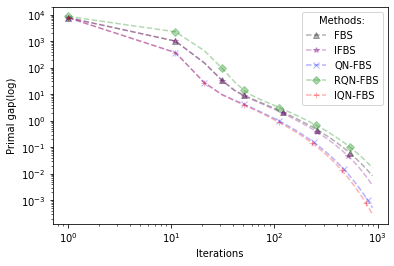

In [119]:
maxnum =int(900/10) 

plt.loglog(x_axis,(np.array(GAP[1:maxnum+1])-GAP[-1]), '^--',markevery=0.1, color='black', alpha=0.3, label='FBS')
plt.loglog(x_axis,(np.array(GAP7[1:maxnum+1])-GAP[-1]), '*--',markevery=0.1, color='purple', alpha=0.3, label='IFBS')

plt.loglog(x_axis,(np.array(GAP5[1:maxnum+1])-GAP[-1]), 'x--',markevery=0.1, color='blue', alpha=0.3, label='QN-FBS')


plt.loglog(x_axis,(np.array(GAP4[1:maxnum+1])-GAP[-1]), 'D--',markevery=0.1, color='green', alpha=0.3, label='RQN-FBS')

plt.loglog(x_axis,(np.array(GAP3[1:maxnum+1])-GAP[-1]), '+--', markevery=0.1,color='red', alpha=0.3, label='IQN-FBS')

plt.xlabel('Iterations')
plt.ylabel('Primal gap(log)')
plt.legend(title='Methods:')
plt.savefig('Image-infimal-concolution(Newtonk^1.1)0.01.pdf')
plt.show()